## Exercise 01.1

In questo primo esercizio si testa il generatore di numeri pseudo-casuali per calcolare il valore medio di una variabile distribuita uniformemente in [0,1) e la sua deviazione standard.

Dato che ogni calcolo Monte Carlo è per sua natura stocastico, per interpretare in modo corretto i valori medi ottenuti è necessaria una stima "empirica" dell'incertezza. Tale stima viene fatta mediante il data-blocking, metodo che permette, se usato correttamente, di ridurre la correlazione residua del generatore di numeri pseudo-casuali. Dati $M$ campionamenti e $N=M/L$ blocchi, con $L$ numero di dati in ogni blocco, le medie e le relative incertezze vengono stimate così: 

$$\sigma^2_A :=\langle (A-\langle A\rangle)^2\rangle = \langle A^2 \rangle -\langle A\rangle^2 $$ dove $$ \langle A^2 \rangle \simeq \frac{1}{N} \sum_{i=1}^N A^2_i \quad \quad \langle A\rangle^2 \simeq \left( \frac{1}{N} \sum_{i=1}^N A_i \right)^2 $$

L'incertezza associata al valor medio si calcola quindi come:

$$\frac{\sigma}{\sqrt{N-1}} \simeq \sqrt{\frac{1}{N-1} \left[ \frac{1}{N} \sum_{i=1}^N A^2_i - \left(\frac{1}{N} \sum_{i=1}^N A_i \right)^2 \right]} $$

#### 1. Stima valore medio

Il valore medio viene stimato generando $M=10^6$ numeri distribuiti uniformemente in [0,1) e raggruppandoli in $N=100$ blocchi diversi. Il grafico mostra l'andamento di $\langle r \rangle -\frac{1}{2}$, ovvero dell'integrale $\int_0^1 r dr -\frac{1}{2}$. 

La stima è fatta con la media a blocchi, con associata la relativa incertezza. Risulta evidente la riduzione dell'incertezza all'aumentare dei blocchi, consistente con l'aspettazione teorica di $\sigma \sim \frac{1}{\sqrt{N}}$.

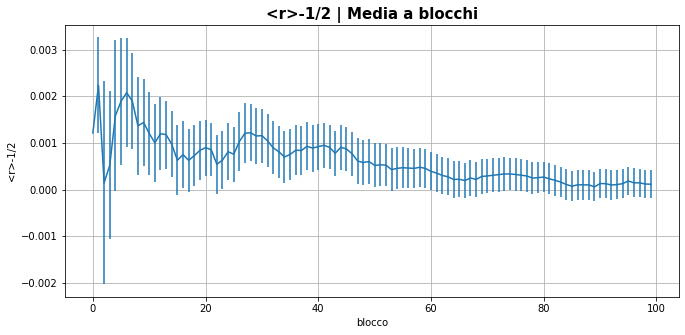

In [50]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

sum_prog, err_prog=np.loadtxt("c++/output/outfileMeanValue.txt", unpack=True)

N=sum_prog.shape[0]
x=np.arange(N)

plt.figure(figsize=(11,5))
plt.errorbar(x,sum_prog-0.5,yerr=err_prog)
plt.title("<r>-1/2 | Media a blocchi", fontsize=15, fontweight="bold")
plt.xlabel('blocco')
plt.ylabel('<r>-1/2')
plt.grid(True)
plt.show()

Si nota che già con $N \sim 50$ il valore teorico atteso è compatibile con la stima Monte Carlo nel limite di circa una deviazione standard.

#### 2. Stima Varianza

In questo caso la varianza è rappresentata dall'integrale $\sigma^2 = \int_0^1 (r-1/2)^2 dr$, verifichiamo la sua convergenza al valore teorico di $1/12$ campionando $r$ da una distribuzione uniforme in [0,1).

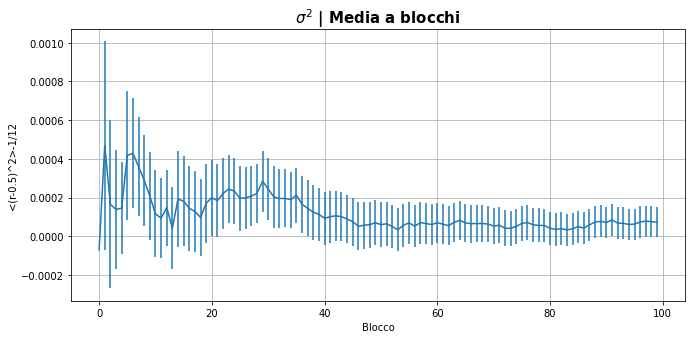

In [51]:
sum_prog, err_prog=np.loadtxt("c++/output/outfileSigma.txt", unpack=True)

N=sum_prog.shape[0]
x=np.arange(N)

plt.figure(figsize=(11,5))

plt.errorbar(x,sum_prog-1/12,yerr=err_prog)
plt.title("$\sigma^2$ | Media a blocchi", fontsize=15, fontweight="bold")
plt.xlabel('Blocco')
plt.ylabel('<(r-0.5)^2>-1/12')
plt.grid(True)
plt.show()

Anche in questo caso si ha compatibilità entro una deviazione standard rispetto al valore atteso. Anche qui le incertezze sscalano come $\sim \frac{1}{\sqrt{N}}$

#### 3. Test del $\chi^2$

Con questo test si vuole verificare che i numeri generati in modo pseudo casuale non si discostino da una distribuzione uniforme. Si è scelto di dividere l'intervallo $[0,1)$ in $M=100$ parti uguali e di calcolare $10^3$ valori di $\chi^2_j$. Il numero totale di dati campionati è indicato con $N_{tot}=10^6$ e quindi per il calcolo di ogni $\chi^2$ sono stati usati $n=10^3$  campionamenti:

$$\chi^2_j = \sum_{i=1}^M \frac{\left( n_{ij} - n/M \right)^2}{n/M}$$

dove $n_{ij}$ indica quanti campionamenti cadono nell'i-esimo intervallo del j-esimo insieme. Invece $n/M=10^3/10^2=10$ è il valore di aspettazione per ognuno degli i-esimi intervalli. 

Si è quindi ottenuto un vettore contenente $10^3$ valori di $\chi^2$ (di valor medio $\sim 100$), che è stato disegnato nel seguente istogramma:

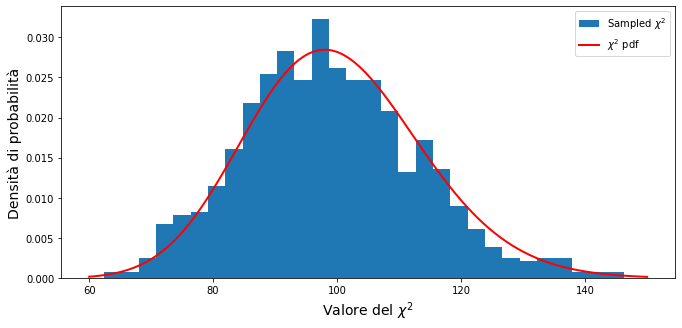

In [52]:
from scipy.stats import chi2

ChiVect=np.loadtxt("c++/output/outfileChi2.txt")

plt.figure(figsize=(11,5))
x = np.linspace(60,150,100)

matplotlib.pyplot.hist(ChiVect,bins=30,density=True, label= "Sampled $\chi^2$")
plt.plot(x, chi2.pdf(x, 100), 'r-', lw=2, label='$\chi^2$ pdf')

plt.xlabel("Valore del $\chi^2$", fontsize=14)
plt.ylabel('Densità di probabilità', fontsize=14)

plt.legend()

Dal grafico è possibile apprezzare la vicinanza tra la distribuzione empirica e quella teorica, che ci permette di "confondere" i nostri numeri pseudo-casuali, in fondo deterministici, con una distribuzione puramente

## Exercise 01.2

In questa parte dell'esercizio implementiamo generatori di numeri casuali che seguono distribuzioni non necessariamente uniformi e verifichiamo la validità del teorema del limite centrale.

Nello specifico sono implementati generatori che seguono le due distribuzioni:

1.   $ p(x) = \lambda exp(-\lambda x)$, con $x \in [0,+\infty)$, ovvero esponenziale
2.   $ p(x) = \frac{1}{\pi}\frac{\Gamma}{(x-\mu)^2+\Gamma^2}$ , con $x \in (-\infty,+\infty)$, ovvero di Cauchy-Lorentz

Per campionare tali distribuzioni invertiamo in modo esplicito le funzioni cumulative (CDF):

1.   $ x=-\frac{1}{\lambda}\log(1-y)$: x è distribuito esponenzialmente se y ha distribuzione uniforme in [0,1)
1.   $ x=\Gamma\tan[\pi(y-\frac{1}{2})]+\mu$: x è distribuito secondo una lorentziana se y ha distribuzione uniforme in [0,1)

Si procede quindi con un'analisi grafica qualitativa del teorema del limite centrale. Si considerano le distribuzioni date dalla somma ($S_N$) rispettivamente di $N=1,2,10,100$ variabili, distribuite prima secondo un'esponenziale e poi secondo una lorentziana. Al crescere delle variabili sommate si può apprezzare come le distribuzioni di partenza tendano ad avvicinarsi oppure no a una distribuzione gaussiana. Sono state campionate $10^5$ variabili $S_N$ per ogni valore di $N$. Per quanto riguarda i parametri si è scelto $\lambda=1$, $\mu=0$ e $\Gamma=1$.

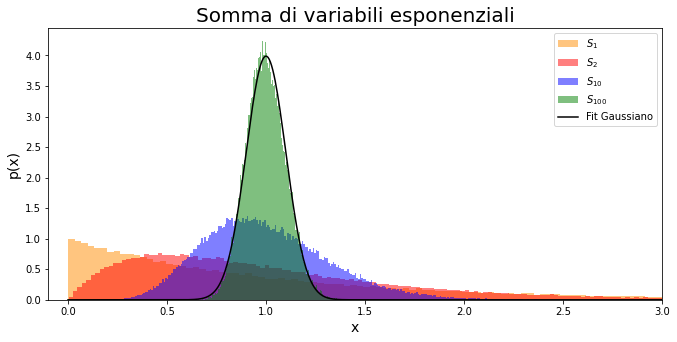

In [53]:
from scipy.stats import norm  

index = ["1","2","10","100"]
color = ['darkorange', "red", "blue", "green"]

x = np.linspace(0.,3,500)

plt.figure(figsize=(11,5))

for i in range (0,4):
    LCTexp = np.loadtxt("c++/output/ExpLCT/outfileLCTexp"+index[i]+".txt")
    matplotlib.pyplot.hist(LCTexp,bins=350, label="$S_{"+index[i]+"}$", density=True,color=color[i], alpha=0.5)

plt.plot(x, norm.pdf(x, 1, 1/10), 'black', lw=1.5, label='Fit Gaussiano',)

plt.title("Somma di variabili esponenziali", fontsize=20)
plt.xlabel("x", fontsize=14)
plt.ylabel('p(x)', fontsize=14) 
plt.xlim(-0.1,3)

plt.legend()   
plt.show()  

Dal grafico è possibile notare che al crescere delle variabili sommate le distribuzioni diventano sempre più simmetriche. Si è deciso di plottare il fit gaussiano nel caso di maggiore somiglianza per mostrare la plausibilità del teorema del limite centrale. Ricordiamo che comunque il teorema non può essere applicato in modo esatto perché la somma delle variabili casuali ha un numero finito di termini.

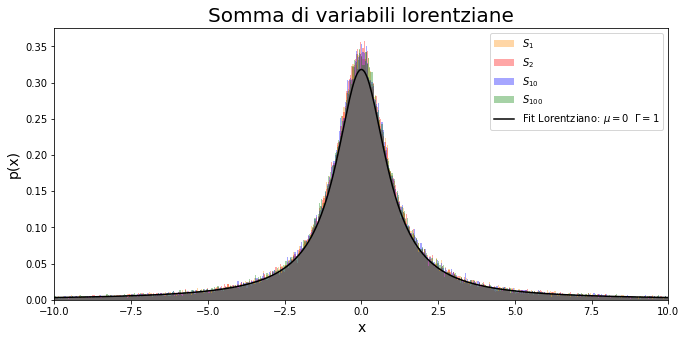

In [54]:
from scipy.stats import cauchy

index = ["1","2","10","100"]
color = ['darkorange', "red", "blue", "green"]
x = np.linspace(-10,10,500)

plt.figure(figsize=(11,5))

for i in range (0,4):
    LCTexp = np.loadtxt("c++/output/LorLCT/outfileLCTlor"+index[i]+".txt")
    matplotlib.pyplot.hist(LCTexp,range = (-10,+10),bins=550, label="$S_{"+index[i]+"}$", density=True,color=color[i], alpha=0.35)

y = cauchy.pdf(x,0,1)
plt.plot(x, y, color = 'black', linestyle = '-', label = "Fit Lorentziano: $\mu=0$  $\Gamma=1$")

plt.title("Somma di variabili lorentziane", fontsize=20)
plt.xlabel("x", fontsize=14)
plt.ylabel('p(x)', fontsize=14) 
plt.xlim(-10,10)

plt.legend()   
plt.show()  

In questo caso, essendo la lorentziana una distribuzione a varianza non finita, il teorema del limite centrale afferma che la distribuzione di target sarà ancora una lorentziana. In questo caso tutte le distribuzioni sono identiche tra loro (la media rimane nulla e la varianza infinita) e sono ben sovrapponibili con una lorentziana centrata nell'origine e di larghezza unitaria.

## Exercise 01.3

In questo esercizio simuliamo l'esperimento di Buffon per la stima di $\pi$. un ago di lunghezza $L$ è lanciato a caso su un piano orizzontale su cui sono presenti linee rette poste a una distanza $d$ ($>L$). La probabilità che l'ago intersechi una di queste linee è data da $P = 2L/\pi d$. Questo ci permette di stimare $\pi$ come:
$$\pi = \frac{2L}{Pd} = \lim_{N_{thr} \to \infty}\frac{2LN_{thr}}{N_{hit}d}$$

Dove $N_{hit}$ rappresenta il numero di volte in cui l'ago ha intersecato una linea, mentre $N_{thr}$ misura il numero totale dei lanci fatti.

Per la simulazione sono stati fissati i seguenti parametri: $N_{thr}=10^5$, $L=1$ e $d=2$. $\pi$ è stato poi stimato con il data blocking considerando 100 blocchi. 

Per ogni lancio si calcola il valore della coordinata perpendicolare alle linee del suolo, che rappresenta la posizione della cruna sul suolo. A questo punto si genera un angolo nell'intervallo $[0,2\pi]$ e si calcola la posizione della punta dell'ago. Se l'ago interseca una linea allora si aumenta il conto di $N_{hit}$.

Un punto delicato da gestire è la generazione dei numeri casuali in $[0,2\pi]$: per non causare circolarità logiche nella simulazione è necessario farlo senza usare iil valore stesso di $\pi$. Per fare ciò si generano coppie di numeri all'interno del rettangolo $[-1,1]x[0,1]$ e con metodo di AR si accettano solo quelli interni alla semicirconferenza inscritta nel rettangolo. Una volta identificato il punto si identifica l'angolo associato calcolando $\theta = \arccos(x/r)$. L'angolo varia in $[0,\pi]$, quindi per considerare la variabile nel range d'interesse è sufficiente moltplicare per 2.

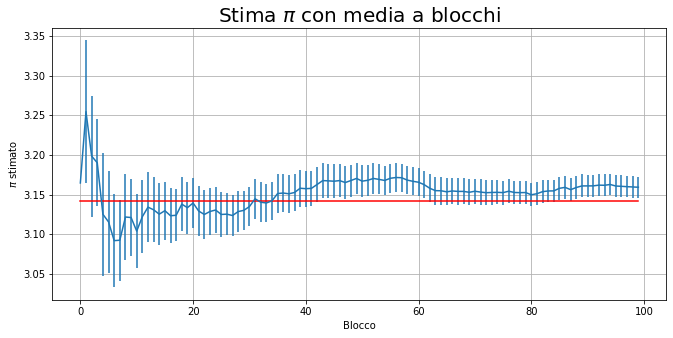

In [55]:
sum_prog, err_prog = np.loadtxt("c++/output/outfile13.txt", unpack=True)

N=sum_prog.shape[0]
x=np.arange(N)
pi_array = np.full(N, np.pi)

plt.figure(figsize=(11,5))
plt.errorbar(x,sum_prog,yerr=err_prog)
plt.plot(x, pi_array, label='pi', color="red")

plt.title("Stima $\pi$ con media a blocchi", fontsize=20)
plt.xlabel('Blocco')
plt.ylabel('$\pi$ stimato')
plt.grid(True)
plt.show()